# Introduction

This notebook expands upon the first notebook in a series that builds a framework for modeling polymer chain adsorption on nanoparticles. This notebook assumes that the first notebook has been studied and understood. It uses much of the code in the first notebook, but creates a code framework around it for rapid exploration of modeling variables.

# Imports, evironment, setting some variables

In [1]:
import numpy as np
from copy import copy
import os

### set to single GPU

In [2]:
# this will pin your CUDA to GPU 0. Using a single GPU is a best practice right now because:
# 1) there's a known bug in NRSS simulation engine that will segfault every 1000 runs or something if you parallelize across energy (NRSS default)
# (we can't seem to find what's doing it), and
# 2) it keeps the other GPUs open for others to use 
# you can check GPU usage with nvidia-smi from command prompt. This will tell you if someone is on GPU 0, and you could choose another from "0","1","2".

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### arguments for eventual function

In [3]:
#specify arguments for model generation
args_default = {}
args_default["ld"] = 512
args_default["vd"] = 256
args_default["radius_nm"] = 17
args_default["PhysSize_nm_per_voxel"] = 0.5
args_default["S0"] = 0.5
args_default["S_slope_per_nm"] = -0.02




args_default["energies"] = np.array([260, 270])
args_default["energies"] = np.append(args_default["energies"], np.arange(275, 283, 1), axis=0)
args_default["energies"] = np.append(args_default["energies"], np.arange(283, 291, 0.1), axis=0)
args_default["energies"] = np.append(args_default["energies"], np.arange(291, 305, 1), axis=0)

We will create an enumerated type to control the qualitative aspect of model creation: the orientation "style," which can be radial, tangential-lat, or tangential-long

In [4]:
from enum import Enum

# class syntax
class EulerStyle(Enum):
    RADIAL = 1
    """
    creates extraordindary index orientation that is radial to the core particle center
    """
    TANGENTIAL_LAT = 2
    """
    creates extraordindary index orientation that is tangential to the core particle center and latitudinal such that all orientations are parallel to the XY plane
    """
    TANGENTIAL_LONG = 3
    """
    creates extraordindary index orientation that is tangential to the core particle center and longitudinal such that all orientations are not parallel to the XY plane except at the north and south poles
    """

In [5]:
args_default["euler_style"] = EulerStyle.RADIAL

<div class="alert alert-block alert-success"><b>Tip:</b> Note that I've added args["euler_style"], which is set by an <a href="https://docs.python.org/3/library/enum.html">enumerated class</a>  that can describe radial or the two types of tangential. This allows the same function to be re-used for different scenarios. When you add additional different styles (like randomly mixed lat and long, or random rotation-about-the-radial), you can add additional enumerated options. <br><br>A similar new enum argument could be used to define the style of S_field, which is currently just linear decay, but could instead be based on erf or other slab models.
</div>

# Import indexes of refraction for polymers and SiO2

For polymers, we will import only the PS index of refraction from the first notebook.

In [6]:
from pandas import read_csv
from NRSS.morphology import OpticalConstants
ps_uni = read_csv("PS_anisotropic_milner_July2024.txt", sep=",")
sio2_uni = read_csv("siox_iso_NIST_Jan2024.txt", sep=",")

args_default["oc_polymer"] = OpticalConstants.calc_constants(args_default["energies"], ps_uni, name="PS")
args_default["oc_particle"] = OpticalConstants.calc_constants(args_default["energies"], sio2_uni, name="SiO2")

CyRSoXS
Size of Real               : 4
Maximum Number Of Material : 32
 __________________________________________________________________________________________________
|                                 Thanks for using CyRSoXS                                        |
|--------------------------------------------------------------------------------------------------|
|  Copyright          : Iowa State University                                                      |
|  License            : NIST                                                                       |
|  Acknowledgement    : ONR MURI                                                                   |
|                                                                                                  |
|  Developed at Iowa State University in collaboration with NIST                                   |
|                                                                                                  |
|  Please cite the fol

<div class="alert alert-block alert-success"><b>Tip:</b> Note I've now made these indices the default ones. This isn't critical, it's mostly so when we copy args_default below, the indices come along for the ride.
</div>

<Axes: title={'center': 'SiO2'}, xlabel='Energy'>

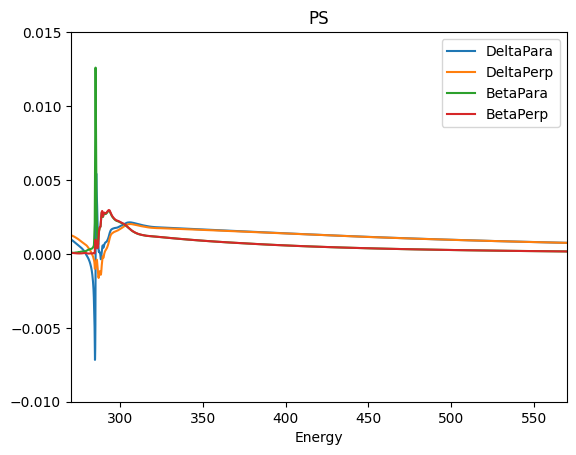

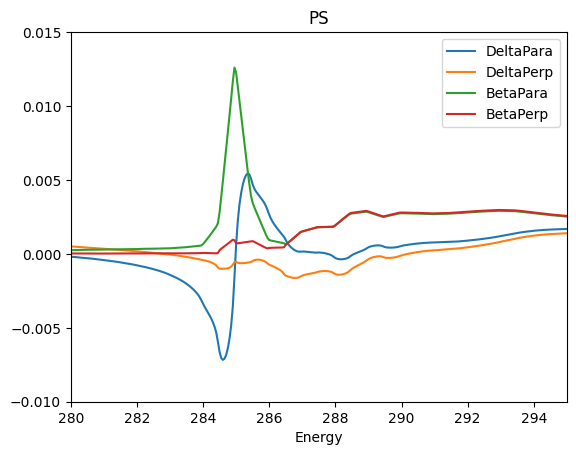

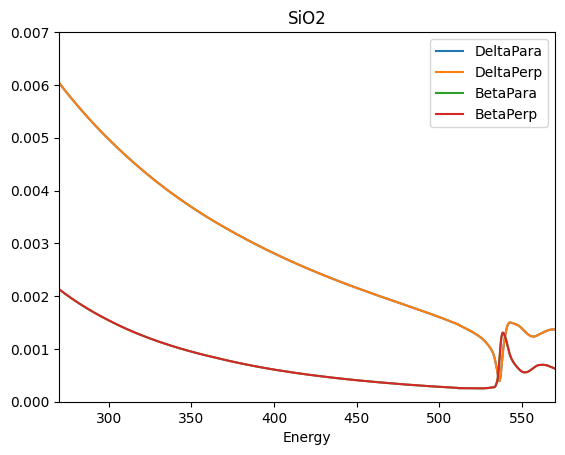

In [7]:
ps_uni.plot(x="Energy", xlim = (270,570), ylim = (-.01,0.015), title = "PS")
ps_uni.plot(x="Energy", xlim = (280,295), ylim = (-.01,0.015), title = "PS")

sio2_uni.plot(x="Energy", xlim = (270,570), ylim = (0,0.007), title = "SiO2")

<div class="alert alert-block alert-success"><b>Tip:</b> Even when you know them by heart, it is a best-practice to always plot the index of refraction that you're using in your model, just in case it has changed somehow on disk, or perhaps there was a Python library update that caused it to import weird.
</div>

# Model construction, now as a function

Our "parametric cartoon" model for adsorbed polymer will be framed here as a function that creates the morphology object. The code is the same (or slightly modified) from the first workbook, but it's now integrated into a Python function.

In [8]:
from NRSS.morphology import Material, Morphology

# note the indentation. Python syntax is defined by indentation
def adsorbed_polymer_morphology(args):
    # it would be best practice here to provide documentation listing all the different args keys and what they do
    # make grid
    z,y,x = np.ogrid[0:args["vd"], 0:args["ld"], 0:args["ld"]]
    # distance from center
    dist_from_ctr = np.sqrt((x - x.mean()) ** 2 + (y - y.mean()) ** 2 + (z - z.mean()) ** 2)
    # boolean sphere
    v_sphere = dist_from_ctr < args["radius_nm"] / args["PhysSize_nm_per_voxel"]

    # Euler angle math
    delta_x = x - args["ld"] / 2
    delta_y = y - args["ld"] / 2
    delta_z = z - args["vd"] / 2

    # the psi and theta for the radial case
    psi = np.arctan2(delta_y, delta_x) + 0*delta_z
    theta = np.arctan2(np.sqrt(delta_x ** 2 + delta_y ** 2), delta_z)
    
    #match - case is similar to a series of if - elseif statements
    match args["euler_style"]:
        case EulerStyle.RADIAL:
            pass
            # do nothing because psi and theta are already correct for radial
        case EulerStyle.TANGENTIAL_LAT:
            # modify the psi and theta for tangential_lat
            theta = np.full_like(theta, np.pi / 2)
            psi = psi - np.pi / 2
        case EulerStyle.TANGENTIAL_LONG:
            # modify the psi and theta for tangential_lon
            psi = psi
            theta = np.where(theta < np.pi / 2, theta + np.pi / 2, theta - np.pi / 2)
        case _:
            # raise a value error if this doesn't come in as one of the enumerated types
            raise ValueError("invalid euler style")
    
    #S-field math
    S_field = args["S0"] + (dist_from_ctr - args["radius_nm"] / args["PhysSize_nm_per_voxel"])*args["S_slope_per_nm"]
    S_field = np.maximum(0, S_field)
    S_field = np.minimum(args["S0"], S_field)
    S_field *= (v_sphere == False)
    
    # constructing the model object
    a_zeros = np.zeros(v_sphere.shape, dtype=np.float32)

    mat1_poly = Material(
        materialID=1,
        Vfrac = (1-v_sphere).astype(np.float32), 
        S=S_field.astype(np.float32),
        theta=theta.astype(np.float32),
        psi=psi.astype(np.float32),
        NumZYX=v_sphere.shape,
        energies=args["energies"],
        opt_constants=args["oc_polymer"].opt_constants,
        name="polymer",
    )

    mat2_particle = Material(
        materialID=2,
        Vfrac=v_sphere.astype(np.float32),
        S=a_zeros,
        theta=a_zeros,
        psi=a_zeros,
        NumZYX=v_sphere.shape, 
        energies=args["energies"],
        opt_constants=args["oc_particle"].opt_constants,    
        name="particle",
    )

    morph = Morphology(
        2,
        {1: mat1_poly, 2: mat2_particle},
        PhysSize=args["PhysSize_nm_per_voxel"],
    )
    # the return statement is what the function delivers as an output
    return morph

# Testing the model generator function for the three Euler styles

## Radial Euler Style

In [9]:
# # default is the radial case (this could be changed by you)
# args = copy(args_default)
# morph = adsorbed_polymer_morphology(args)

In [10]:
# morph.visualize_materials(z_slice = args["vd"]//2, subsample = 256)

## Tangential-Lat Euler Style


In [11]:
# args = copy(args_default)
# # after copying default args, we can change the args["euler_style"]
# args["euler_style"] = EulerStyle.TANGENTIAL_LAT
# morph = adsorbed_polymer_morphology(args)

In [12]:
# morph.visualize_materials(z_slice = args["vd"]//2, subsample = 256)

## Tangential-Lon Euler Style

In [13]:
# args = copy(args_default)
# # after copying default args, we can change the args["euler_style"]
# args["euler_style"] = EulerStyle.TANGENTIAL_LONG
# morph = adsorbed_polymer_morphology(args)

In [14]:
# morph.visualize_materials(z_slice = args["vd"]//2, subsample = 256)

Everything checks out for all three radial styles. When you write a function like this, it's important to test all of its cases / options.

# Function that constructs AND runs the model

Now that we're familiar with functions, we're going to advance our framework by making a function that makes the model object runs it, and saves the results.  <br><br>It will use our model-making function above so we don't rewrite it. Rewriting it would be bad because then it would be written in two places, and changes in one would not convey to the other. This style of function-within-a-function-within-a-function (function-ception?) is extremely common in all computer coding. If everything is well-documented, then it's all good.

In [15]:
from PyHyperScattering.integrate import WPIntegrator

def adsorbed_polymer_run(args):
    # notice how we're passing args to the adsorbed_polymer_morphology function
    # we could also have args that affect how the model is run (but we don't right now)
    
    # we start right away with the adsorbed_polymer_morphology function
    morph = adsorbed_polymer_morphology(args)
    
    # FFT "window" parameter
    morph.inputData.windowingType = 0  # cy.FFTWindowing.Hanning

    # that rotation function we don't need bc your model is radially symmetric
    morph.EAngleRotation = [0.0, 0.0, 0.0]

    # we will keep the validator in here. Always good to check the morphology your function made
    morph.validate_all(quiet=False)

    #this actually runs the model
    data = morph.run(stdout=True, stderr=False)

    # the PyHyperScattering part for interpreting the model result
    integrator = WPIntegrator(use_chunked_processing=False)
    remeshed_data = integrator.integrateImageStack(data)
    
    # we will use a pythin dictionary for holding the results
    results = {}
    
    results["I"] = remeshed_data.mean(dim="chi")
    results["A"] = remeshed_data.rsoxs.AR(chi_width = 45)
    
    # note, in addition to the model output, you could also return other things like the visualization results (which you might want to see, for parameter sweeps)
    # morphology.visualize_materials has a huge number of potential arguments to tailor what it shows about the model and how it shows it
    results["visualizations"] =  morph.visualize_materials(z_slice = args["vd"]//2, subsample = 256, outputplot = ["vfrac", "S", "psi", "theta"], outputmat = [1], runquiet = True)
    
    # also, it's a great idea to store the args dictionary in the results
    # that creates a durable record of what the parameters were when you simulated
    results["args"] = args 
 
    # you could choose to return a variety of information. 
    # for example, you could return the data object and/or the remeshed_data object
    # if you wanted to see full 2D patterns
    # I'm choosing only I and A, which are reductions of the data, but ones focused on our inquiry
    # I'm also returning the visualizations created above
    
    # note we return the results dictionary, which has I, A, and visualizations stored in it
    return results

Imports failed.  Are you running on a machine with proper libraries for databroker, tiled, etc.?


TypeError: constants must be of type bool/int/long/float/double/complex/bytes

## Testing this function that constructs and runs the model

In [16]:
args = copy(args_default)
args["euler_style"] = EulerStyle.TANGENTIAL_LAT
results = adsorbed_polymer_run(args)

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

ValueError: dimensions () must have the same length as the number of data dimensions, ndim=1

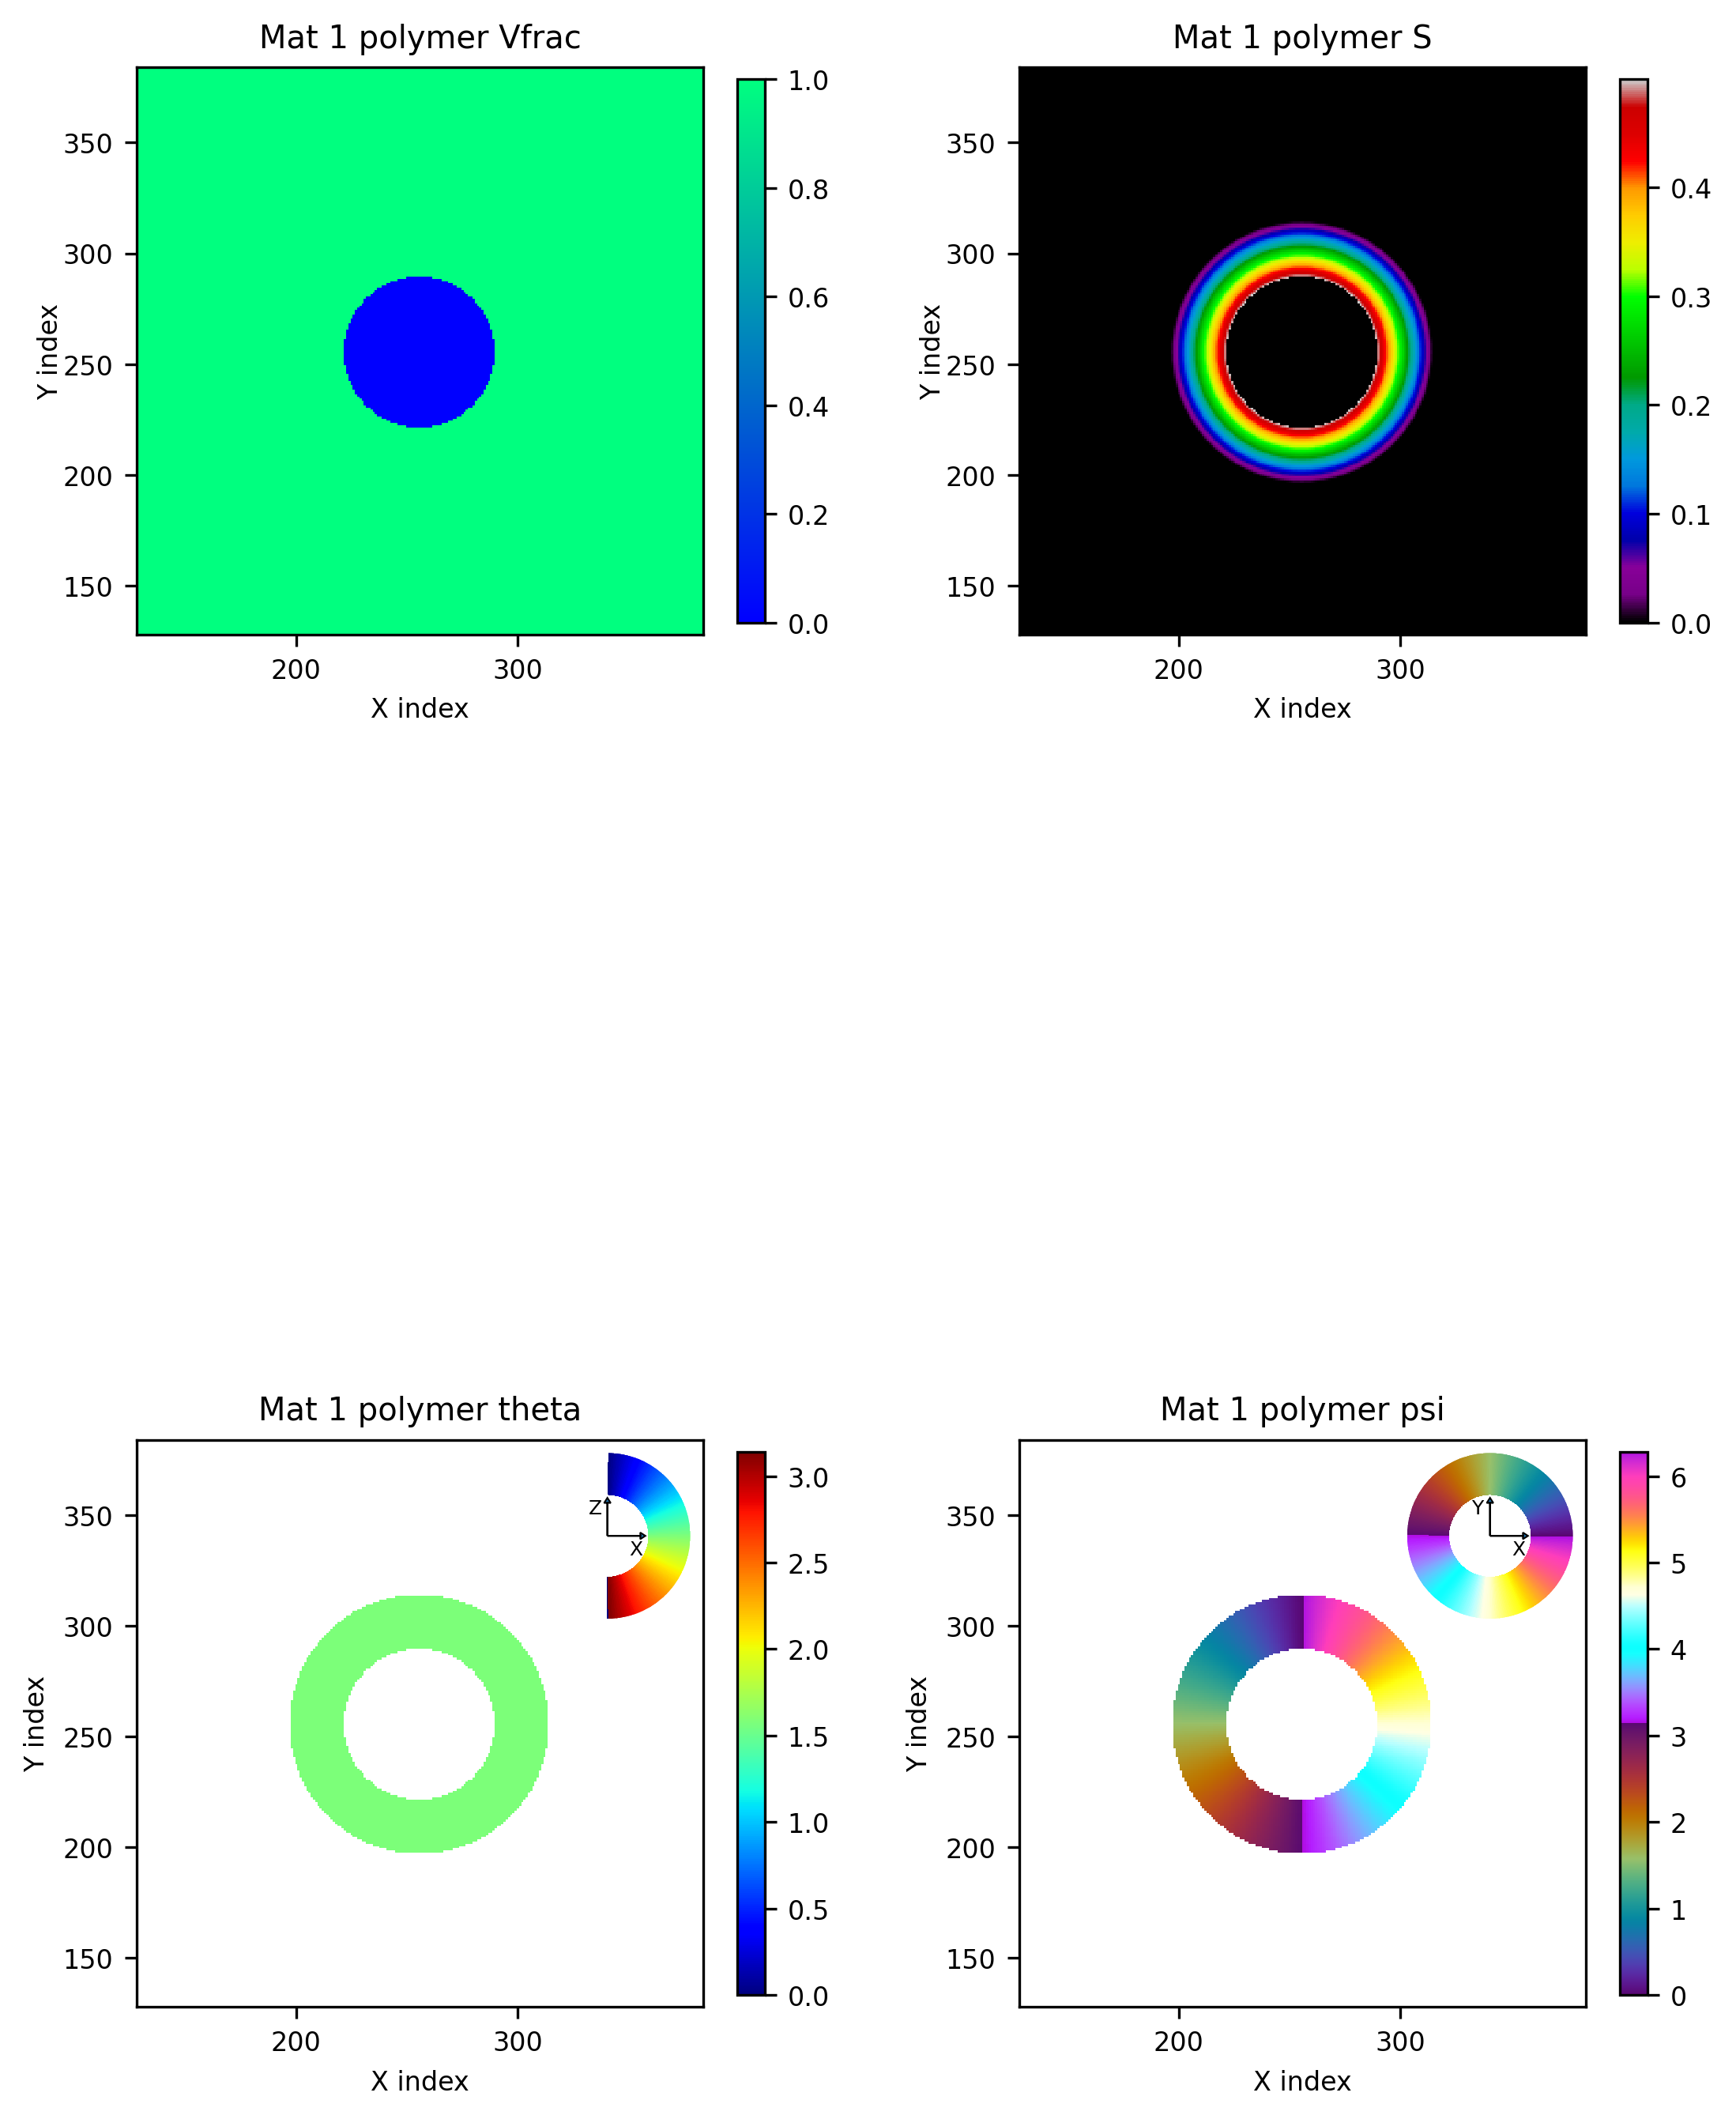

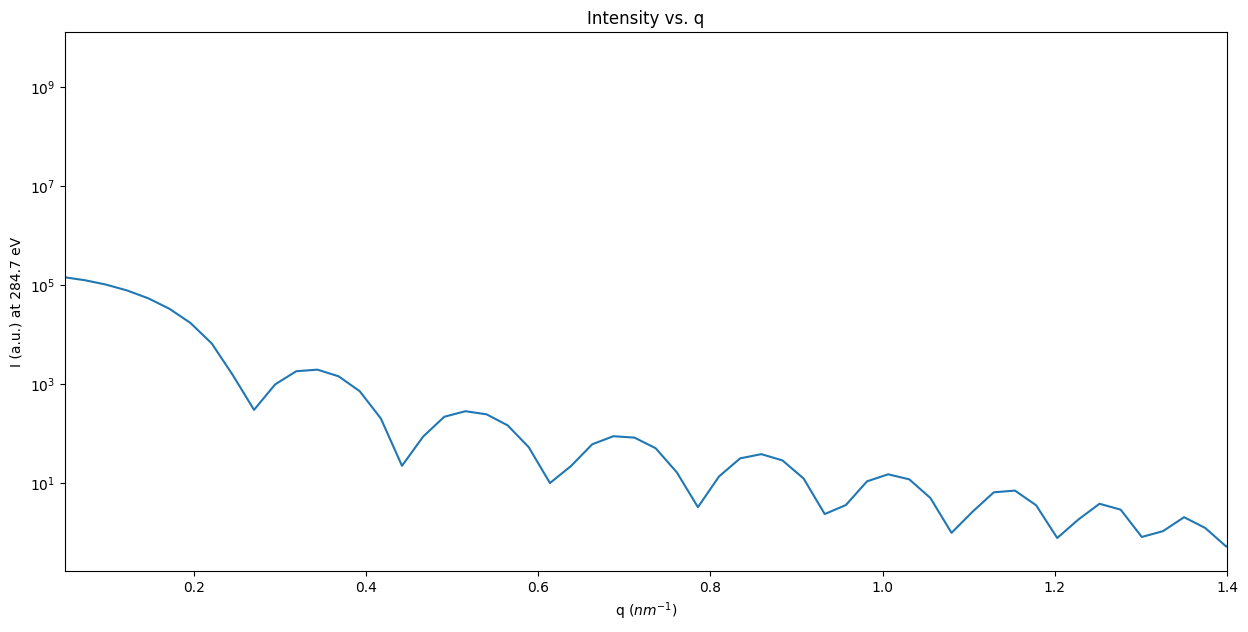

In [17]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize = (15,7))
results["I"].sel(energy = 284.7, method = 'nearest').plot(ax = ax, yscale = "log", xlim = (0.05, 1.4))
plt.title(f"Intensity vs. q")
plt.xlabel("q ($nm^{-1}$)")
plt.ylabel("I (a.u.) at 284.7 eV")
plt.show()

Text(0, 0.5, 'energy (eV)')

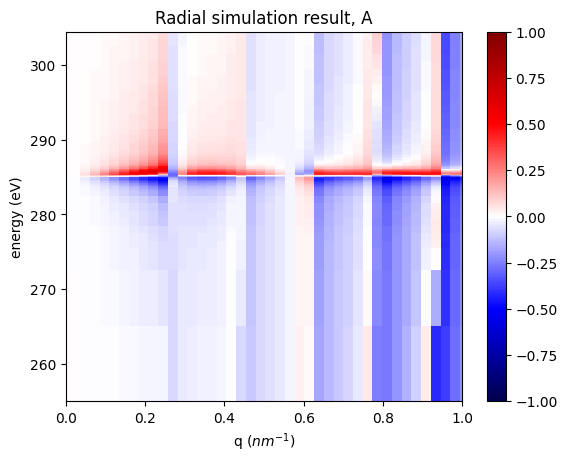

In [18]:
results["A"].plot(xlim=(0,1.0), vmin = -1, vmax = 1, cmap = 'seismic')
plt.title(f"Radial simulation result, A")
plt.xlabel("q ($nm^{-1}$)")
plt.ylabel("energy (eV)")

Note we are no longer running visualization code on the morphology model. In fact the model no longer exists in memory. Instead, we're displaying its saved and returned visualizations that were created inside the function when the model did exist.

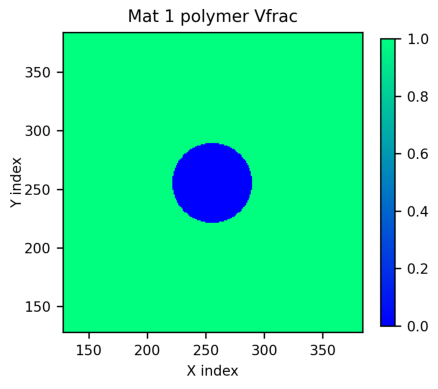

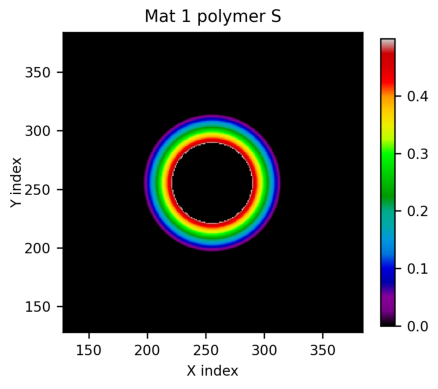

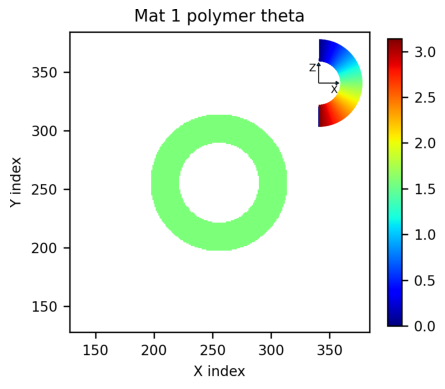

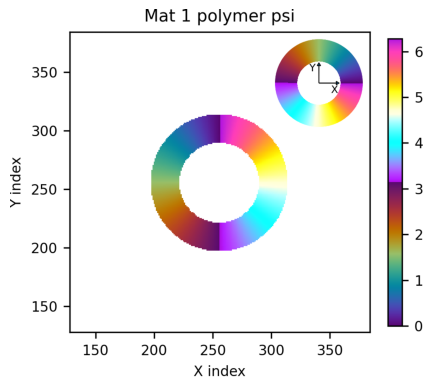

In [19]:
# this kind of loop is very common in Python; some might say it's very "Pythonic." 
# It sets visualization to each value of the visualizations list, and performs the indented code on it, in sequence
for visualization in results["visualizations"]:
    plt.imshow(visualization)
    plt.gca().axis("off")
    plt.show()
    plt.close()

# Function that constructs AND runs AND saves the results to disk

The idea here is that since simulations take several minutes, it makes sense to save the results to disk and examine them at your leisure, even potentially within a different notebook.<br><br> We will use "pickle" for saving the results, but there are other ways we could save them - for example in xarray native format. Pickle is "easy" and works for many datatypes. But it is not good for passing data from environment to environment or user-to-user, because pickle expects all the same libraries (and their versions) to be loaded when the file is unpickled as when it was pickled. <br><br>Just like before, we're going to build on the functions that were previously written.

In [20]:
import pickle, lzma
from pathlib import Path

def adsorbed_polymer_run_save(args):
    
    # we jump straight to the results dictionary
    results = adsorbed_polymer_run(args)
    
    # now we save the results to a pickle file
    # note that we need a file name! We can use a new entry in the args dictionary
    # also we need  a directory to save the file in. 
    # For convenience, I've hardcoded a "pickles" subdirectory in the current working directory
    
    # this syntax is using the pathlib module. Some older styles might just use strings for this
    # Path.cwd() returns the current working directory    
    
    savefile_path_and_name = Path.cwd() / "pickles" / args["filename"]
    
    # lzma is a hardcore compression library we're using with pickle to keep the file size down
    with lzma.open(savefile_path_and_name, 'wb') as handle:
        pickle.dump(results, handle, protocol = pickle.HIGHEST_PROTOCOL)
        
    # note there is nothing to return here. The results are stored in the pickled results dictionary

In [21]:
args = copy(args_default)
args["euler_style"] = EulerStyle.TANGENTIAL_LAT
args["filename"] = "adsorbed_polymer_tangential_lat.pkl"

adsorbed_polymer_run_save(args)

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

You can verify the file is there. It's not easy to read the file (one issue with pickles), but we will show how to unpickle files later.